# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
#загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
#Загрузка файла с данными:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
#Извлечение данных: 
datagen = ImageDataGenerator(rescale = 1/255)
train_datagen_flow = datagen.flow_from_dataframe(
        dataframe= labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [4]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [5]:
labels.shape

(7591, 2)

In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


**Выводы:** имеем 7591 - изображение, пропусков нет, тип данных менять не нужно.

Text(0.5, 1.0, 'График распределения возраста в выборке')

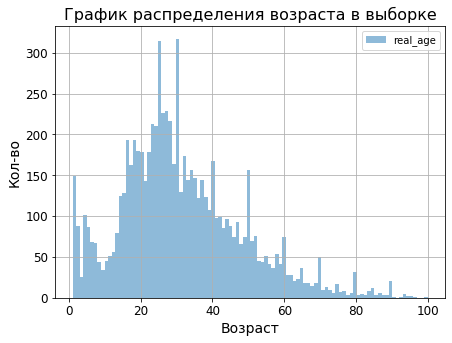

In [7]:
labels.plot(grid = True, style = 'o', figsize = (7, 5), kind= 'hist', subplots = True, bins=100, alpha=0.5, fontsize=12)
plt.xlabel("Возраст", fontsize=14)
plt.ylabel("Кол-во", fontsize=14)
plt.title('График распределения возраста в выборке', fontsize=16)

Text(0.5, 1.0, 'Диаграмма размаха возраста в выборке')

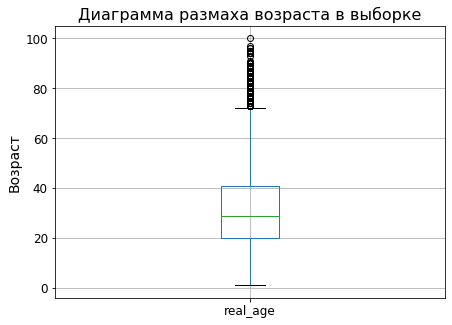

In [8]:
labels.plot(grid = True, style = 'o', figsize = (7, 5), kind= 'box', subplots = True, fontsize=12)
plt.ylabel("Возраст", fontsize=14)
plt.title('Диаграмма размаха возраста в выборке', fontsize=16)

In [9]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


**Выводы:** 
По гистограмме можно увидеть, что данные имеют нормальное распределение, при этом имеют положительную скошенность. Вероятно, пики с круглыми датами связаны с предобработкой датасета, когда выбирались значения для подстановки, либо связаны с выбором фотографий с различных платформ, где возраст указывался приближено (пример: старше 30, старше 35 и т.д.)


По диаграмма размаха видно, что нижний ус упирается в минимум - 1 год, верхний - в значение около 73 лет. Это ориентировочная граница нормального размаха. Значения, которые отсёк верхний ус - редкие, о чём можно судить по тому, насколько медиана не стремится к длинному хвосту высоких значений, при этом не противоречат логике, так как люди могут жить и дольше ста лет (максимум выборки - 100 лет).


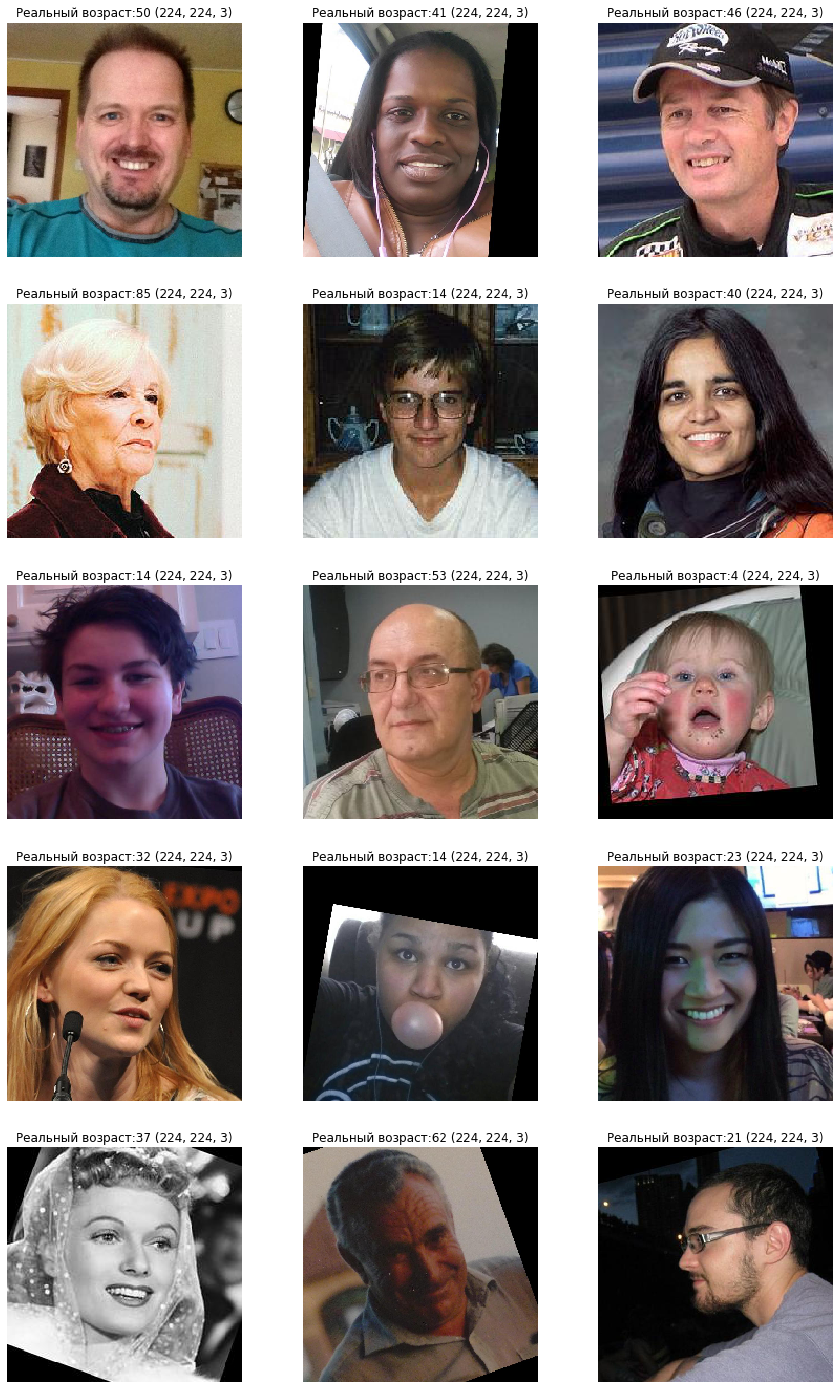

In [10]:
faces, ages = next(train_datagen_flow)
ROWS = 5
COLS = 3
fig, axes = plt.subplots(nrows = ROWS, ncols = COLS)
fig.set_figheight(5 * ROWS)
fig.set_figwidth(5* COLS)
for ax, img, age in zip(axes.flat, faces[:15], ages[:15]):
    ax.imshow(img)
    ax.set(title =f'Реальный возраст:{age} {img.shape}')
    ax.axis('off')
plt.show()    

**Выводы:** имеем изображения различных цветов, яркости, контрастности, чёткости, с разным количеством шумов и различными углами поворота, также присутствуют постороние предметы, что может привести к низкому качеству итоговой модели. Возможно улучшение качества моделей с помощью аугментаций.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
 
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       validation_split=0.25, 
                                       horizontal_flip=True)
 
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels, 
                                                           directory=path + 'final_files/', 
                                                           x_col='file_name', 
                                                           y_col='real_age', 
                                                           target_size=(224, 224), 
                                                           batch_size=20, 
                                                           class_mode='raw', 
                                                           subset='training', 
                                                           seed=12345)
    return train_datagen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
 
    test_datagen = ImageDataGenerator(rescale=1./255, 
                                      validation_split=0.25)
 
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels, 
                                                         directory=path + 'final_files/', 
                                                         x_col='file_name', 
                                                         y_col='real_age', 
                                                         target_size=(224, 224), 
                                                         batch_size=20, 
                                                         class_mode='raw', 
                                                         subset='validation', 
                                                         seed=12345)
    return test_datagen_flow
 
def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, 
                  loss='mse', 
                  metrics=['mae'])
 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=30, 
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model

```

```

Train for 285 steps, validate for 95 steps
Epoch 1/30
2021-11-10 09:45:06.347507: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-10 09:45:06.684943: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
285/285 - 47s - loss: 204.3119 - mae: 10.4103 - val_loss: 663.6901 - val_mae: 20.7907
Epoch 2/30
285/285 - 38s - loss: 78.8133 - mae: 6.7133 - val_loss: 296.8162 - val_mae: 12.5515
Epoch 3/30
285/285 - 38s - loss: 53.9215 - mae: 5.6533 - val_loss: 94.4780 - val_mae: 7.2885
Epoch 4/30
285/285 - 39s - loss: 38.9556 - mae: 4.7790 - val_loss: 103.3157 - val_mae: 7.6160
Epoch 5/30
285/285 - 39s - loss: 33.1592 - mae: 4.3872 - val_loss: 72.4910 - val_mae: 6.4681
Epoch 6/30
285/285 - 39s - loss: 24.1534 - mae: 3.7916 - val_loss: 73.8177 - val_mae: 6.2956
Epoch 7/30
285/285 - 39s - loss: 19.3644 - mae: 3.3380 - val_loss: 66.5727 - val_mae: 6.1690
Epoch 8/30
285/285 - 38s - loss: 15.6534 - mae: 2.9984 - val_loss: 72.1584 - val_mae: 6.4500
Epoch 9/30
285/285 - 39s - loss: 13.5164 - mae: 2.7555 - val_loss: 71.4630 - val_mae: 6.2894
Epoch 10/30
285/285 - 39s - loss: 12.6659 - mae: 2.6674 - val_loss: 81.9903 - val_mae: 6.6366
Epoch 11/30
285/285 - 38s - loss: 11.8510 - mae: 2.5892 - val_loss: 69.9411 - val_mae: 6.1225
Epoch 12/30
285/285 - 38s - loss: 10.3293 - mae: 2.4328 - val_loss: 63.0891 - val_mae: 5.8669
Epoch 13/30
285/285 - 38s - loss: 9.2271 - mae: 2.3062 - val_loss: 70.1938 - val_mae: 6.3365
Epoch 14/30
285/285 - 38s - loss: 9.1112 - mae: 2.3144 - val_loss: 67.9732 - val_mae: 6.0131
Epoch 15/30
285/285 - 39s - loss: 8.8683 - mae: 2.2461 - val_loss: 67.3554 - val_mae: 6.0230
Epoch 16/30
285/285 - 38s - loss: 8.5222 - mae: 2.2251 - val_loss: 63.5892 - val_mae: 5.9328
Epoch 17/30
285/285 - 38s - loss: 8.5121 - mae: 2.2071 - val_loss: 63.0139 - val_mae: 5.8342
Epoch 18/30
285/285 - 38s - loss: 8.0820 - mae: 2.1864 - val_loss: 59.5479 - val_mae: 5.7886
Epoch 19/30
285/285 - 38s - loss: 8.0360 - mae: 2.1303 - val_loss: 67.2839 - val_mae: 6.0870
Epoch 20/30
285/285 - 38s - loss: 8.5282 - mae: 2.2114 - val_loss: 65.4000 - val_mae: 6.0903
Epoch 21/30
285/285 - 38s - loss: 8.1816 - mae: 2.1718 - val_loss: 65.1848 - val_mae: 6.1011
Epoch 22/30
285/285 - 38s - loss: 9.4084 - mae: 2.3335 - val_loss: 61.7112 - val_mae: 5.8035
Epoch 23/30
285/285 - 39s - loss: 9.6163 - mae: 2.3824 - val_loss: 70.6077 - val_mae: 6.1855
Epoch 24/30
285/285 - 39s - loss: 13.8093 - mae: 2.7584 - val_loss: 73.4408 - val_mae: 6.4814
Epoch 25/30
285/285 - 38s - loss: 11.3252 - mae: 2.5440 - val_loss: 57.8600 - val_mae: 5.6115
Epoch 26/30
285/285 - 38s - loss: 7.5241 - mae: 2.0796 - val_loss: 59.6406 - val_mae: 5.8319
Epoch 27/30
285/285 - 39s - loss: 5.4621 - mae: 1.7581 - val_loss: 56.3375 - val_mae: 5.5146
Epoch 28/30
285/285 - 38s - loss: 4.6259 - mae: 1.6096 - val_loss: 58.3275 - val_mae: 5.5760
Epoch 29/30
285/285 - 38s - loss: 4.2960 - mae: 1.5569 - val_loss: 55.2505 - val_mae: 5.5236
Epoch 30/30
285/285 - 38s - loss: 4.1790 - mae: 1.5292 - val_loss: 58.2349 - val_mae: 5.6450
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
95/95 - 10s - loss: 58.2349 - mae: 5.6450
Test MAE: 5.6450
# < длинные строки со скачиванием модели можно удалить >

```

## Анализ обученной модели

В статье о датасете, с которым мы работали, значение MAE равно 5.4. полученный результат 5.64 - адекватный. 
Данные были загружены и проанализированы, имеем слудующие выводы:
* данные распределены нормально со скошенностью вправо, при этом выбросы не противоречат логике;
* изображения имееют разные цвет, контрастность, чёткость, угол поворота и позиционирование, что усложняет обучение модели;
* Для ускорения обучения модели применили алгоритм ADAM, для увеличения качества архитектуру ResNet, для уменьшения кол-ва параметров применили пуллинг.
Результат: Test MAE: 5.6450